In [32]:
from MVN import MultivariateNormal
from MCMC import MetropolisHastings, Gibbs, Cholesky, SampleSet2D
from multiple_chains import MultipleChains, errors_sampler, plot_errors
from tqdm import tqdm

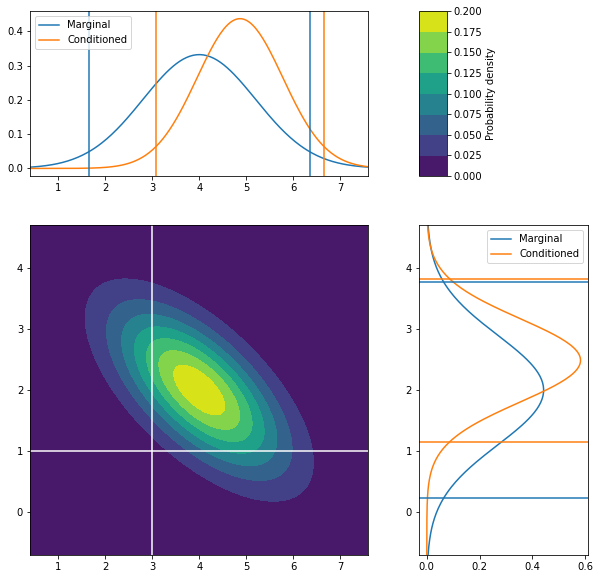

In [34]:
mean = np.array([4, 2])
covariance = np.array([
    [1.44, -.702],
    [-.702, .81]])

CL = .95

n = MultivariateNormal(mean, covariance)
# this class, defined in a separate file, has all the properties we need

n.plot_2d_analytical(3, 1, CL)
# bivariate plot of the Gaussian, including marginal distributions
# and conditioned distributions on the values provided as arguments
# and credible intervals for each univariate Gaussian 

In [36]:
# Let us see some numbers

mx = n.marginalize(0)
CI_x_analytical = mx.analytical_CI(CL)
my = n.marginalize(1)
CI_y_analytical = my.analytical_CI(CL)
print(f'The Credible Interval for x is between {CI_x_analytical[0]:.2f} and {CI_x_analytical[1]:.2f}')
print(f'The Credible Interval for y is between {CI_y_analytical[0]:.2f} and {CI_y_analytical[1]:.2f}')

The Credible Interval for x is between 1.65 and 6.35
The Credible Interval for y is between 0.24 and 3.76


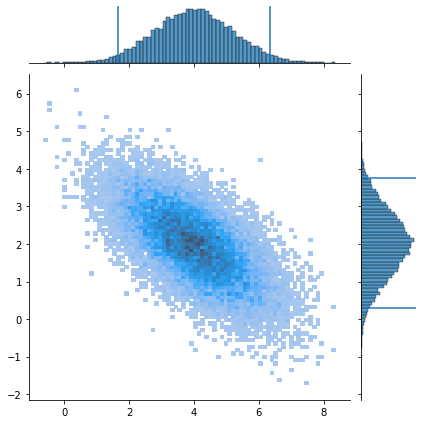

In [38]:
# CHOLESKY SAMPLING

samples_ch = SampleSet2D(n.cholesky_sample(20000))
samples_ch.samples_plot(.95, kind='hist')

In [40]:
# METROPOLIS - HASTINGS SAMPLING

# def gaussian_proposal(theta=None):
#     return (np.random.normal(scale=1, size=2))
from numpy.random import default_rng

def gaussian_proposal(theta=None):
    rng = default_rng()
    return(rng.standard_normal(size=2))

num_chains = 7
spread_initial_positions = 10
initial_positions = np.random.normal(scale=spread_initial_positions, size=(num_chains, 2))

chain_length = 200

mh = MultipleChains(MetropolisHastings, n.pdf, initial_positions,
                       chain_length, gaussian_proposal)

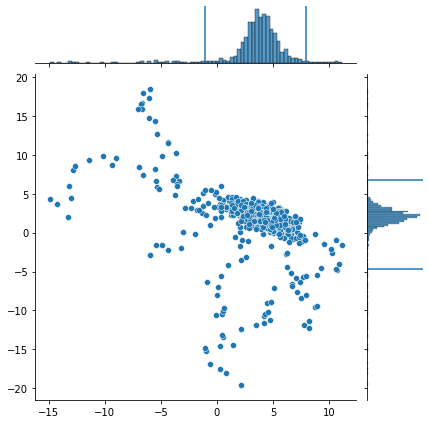

In [42]:
samples_mh = SampleSet2D(mh.all_chains)
samples_mh.samples_plot(CL, kind='scatter')

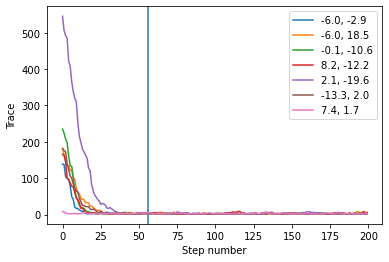

In [44]:
plt.axvline(mh.optimal_trimming)
mh.traces_plot(every=1)

In [46]:
mh.trim_chains(mh.optimal_trimming)
mh.extend_chains(int(1e4))

Trimming at 56


In [48]:
print(mh.R_estimator()) # < 1.02 in all its entries!
print(mh.autocorrelation_times()) # all close to 1! great
# am I underestimating these?

[[1.00035148 1.00049567]
 [1.00049567 1.00031054]]
[1.0009372977678361, 1.0001620678941625, 1.0002785945495332, 1.0003304066263796, 1.0010193466677177, 1.000586709738754, 1.0004248261411242]


In [50]:
# SampleSet2D(mh.all_chains).samples_plot(CL, kind='kde')

In [52]:
# GIBBS SAMPLING
# from our distribution n

def conditional(i, theta):
    rng = default_rng()
    deviate = rng.standard_normal()
    
    conditioned = n.condition(i, theta[1-i])
    sigma = np.sqrt(conditioned.cov)
    return((conditioned.mean + sigma * deviate)[0,0])

g = MultipleChains(Gibbs, n.pdf, initial_positions, chain_length, conditional)


Trimming at 8


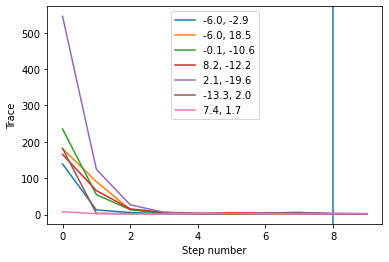

In [54]:
plt.axvline(g.optimal_trimming)
g.traces_plot(every=1)
g.trim_chains(g.optimal_trimming)

In [56]:
g.extend_chains(int(1e3))

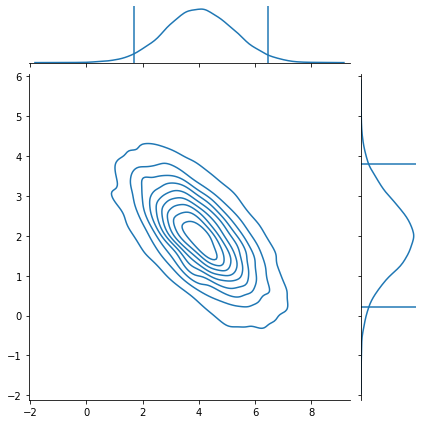

In [58]:
SampleSet2D(g.all_chains).samples_plot(CL, kind='kde')

In [80]:
chain_length = 10
mc_1 = MultipleChains(Gibbs, n.pdf, initial_positions[:5], chain_length, conditional)
# mc_1 = MultipleChains(MetropolisHastings, n.pdf, initial_positions[:5], chain_length, gaussian_proposal)
# mc_1 = MultipleChains(Cholesky, n.pdf, initial_positions, chain_length, n.cholesky_sample)

trimming_index = 40
N, e_mean, e_cov = errors_sampler(mc_1, n, max_num=int(1e6), trimming_index=trimming_index)

40it [00:04,  6.78it/s]Trimming at 4
200it [21:45,  6.53s/it]


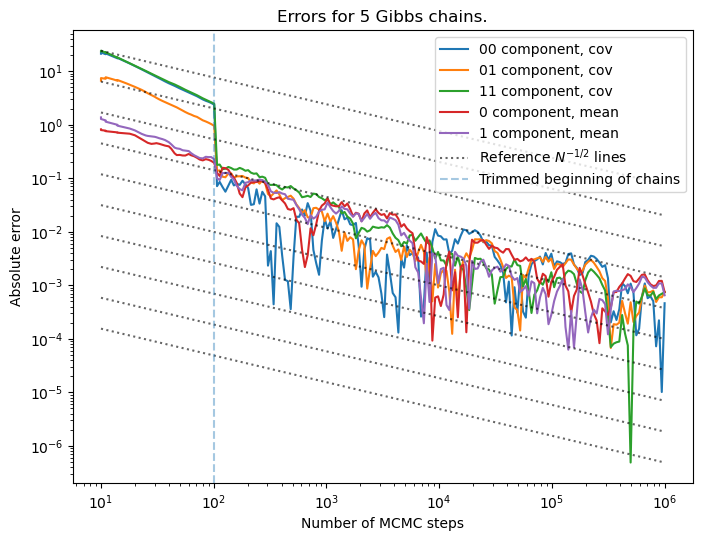

In [81]:
plot_errors(N, e_mean, e_cov, mc_1, trimming_index=trimming_index)
plt.savefig('errors_gi_2.pdf')

In [61]:
SS = SampleSet2D(g.all_chains)
x, y, z = SS.kde()

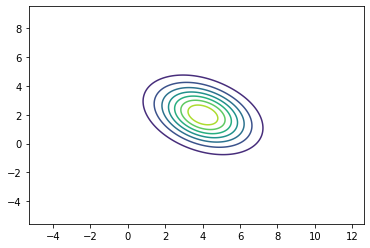

In [62]:
plt.contour(x, y, z)

In [67]:
yc, zc = SS.conditional_kde(0, 1)
cs = SS.conditional_cut(0, 1, .2)

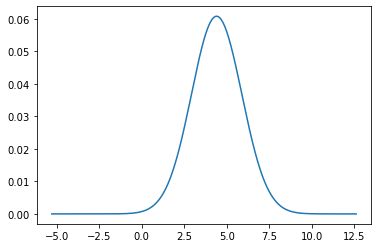

In [68]:
plt.plot(yc, zc)

(array([ 7.,  8., 19., 30., 50., 49., 74., 73., 86., 80., 63., 47., 34.,
        12., 17.,  4.,  3.,  0.,  0.,  1.]),
 array([2.46871095, 2.76196967, 3.0552284 , 3.34848712, 3.64174585,
        3.93500458, 4.2282633 , 4.52152203, 4.81478075, 5.10803948,
        5.40129821, 5.69455693, 5.98781566, 6.28107438, 6.57433311,
        6.86759184, 7.16085056, 7.45410929, 7.74736801, 8.04062674,
        8.33388547]),
 <BarContainer object of 20 artists>)

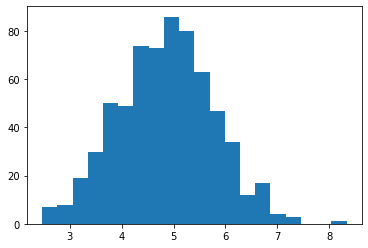

In [69]:
plt.hist(cs[:,0], bins=20)

In [75]:
cs.shape

(657, 2)